# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [1]:
#!pip list
#!pip install --upgrade --user tensorflow==2.11.0

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2023-04-06 16:34:02.837482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 16:34:10.820024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-06 16:34:10.821184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [2]:
images_dir = '../data/images/'
masks_dir = '../data/masks/'
img_size = (64, 64)

val_split = 16 # % of total dataset to be used for validation
test_split = 16 # % of total dataset to be used for testing
val_batch_size = 1 # batch size per step
test_batch_size = 1
batch_size = 16

### Load Dataset and Split Into Subsets

In [3]:
images_ds = tf.keras.utils.image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=None)

masks_ds = tf.keras.utils.image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=None)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))

train_ds, test_ds = tf.keras.utils.split_dataset(dataset, 
                                 right_size=test_split/100, 
                                 shuffle=False)

train_ds, val_ds = tf.keras.utils.split_dataset(train_ds, 
                                 right_size=val_split/(100-test_split), 
                                 shuffle=False)

val_ds = val_ds.batch(val_batch_size)
test_ds = test_ds.batch(test_batch_size)

Found 100 files belonging to 1 classes.


2023-04-06 16:34:19.637581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 16:34:20.351339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 16:34:20.351635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 16:34:20.381818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 100 files belonging to 1 classes.


### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the training images from the dataset.

In [7]:
def augment(image, mask):
    
    aug_model = keras.Sequential(
        layers = [
            layers.RandomFlip(mode="horizontal_and_vertical"),
            layers.RandomRotation(0.8, fill_mode="constant", interpolation='bilinear', fill_value=0),
            layers.RandomTranslation(0.2,0.2, fill_mode="constant", interpolation='bilinear', fill_value=0),
            #layers.RandomZoom((-0.01, 0.01),(-0.01, 0.01),interpolation='nearest'),
        ]
    )

    image_mask = tf.concat([image, mask], -1)
    image_mask = aug_model(image_mask)
    
    image = image_mask[:,:,:,0]
    mask = image_mask[:,:,:,1]
    
    image = tf.reshape(image, [-1, img_size[0], img_size[1], 1])
    mask = tf.reshape(mask, [-1, img_size[0], img_size[1], 1])
    
    return image, mask

aug_dataset = (
	train_ds
    .repeat()
    .batch(batch_size)
    .map(lambda img,msk: augment(img, msk))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the augmented dataset of overlayed image segmentations.

2023-04-06 16:36:06.879087: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


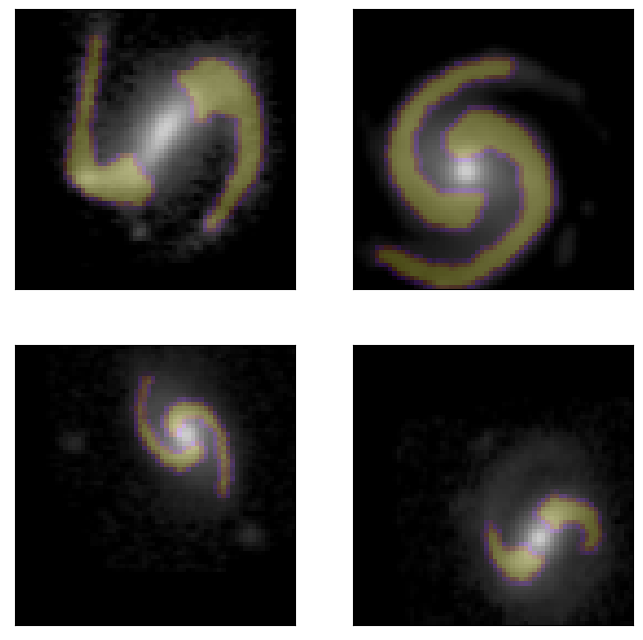

In [12]:
plt.figure(figsize=(8,8))

offset = np.random.randint(60)

for n, (image, mask) in aug_dataset.unbatch().take(4).enumerate(start=offset).as_numpy_iterator():
    
    plt.subplot(2,2,n-offset+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Pre-Build Augmented Data of Set Size



In [7]:
batch_size = 16
train_ds_aug = aug_dataset.unbatch().shuffle(1).take(10000).batch(batch_size)

## [3] Build Model

In [13]:
def get_unet(start_neurons = 16, kernel_size=(3, 3), dropout_prob=0.2):
    
    inputs = keras.Input(shape=img_size + (1,))
    
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_prob)(p1)    

    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_prob)(p2)

    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = layers.Dropout(dropout_prob)(c3)
    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_prob)(p3)

    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    #c4 = layers.Dropout(dropout_prob)(c4)
    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = layers.Dropout(dropout_prob)(p4)

    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    #c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(start_neurons*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout_prob)(u6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    #c6 = layers.Dropout(dropout_prob)(c6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(start_neurons*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout_prob)(u7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = layers.Dropout(dropout_prob)(c7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(start_neurons*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout_prob)(u8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout_prob)(u9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return keras.Model(inputs, outputs, name='U-Net')

#get_unet(8).summary()

## [4] Train Model

In [9]:
# Ensure tensorflow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')

if(len(physical_devices) > 0):
    print(f"Number of GPUs: {len(physical_devices)}")
else:
    print("No GPU detected... Running on CPU")
    
!nvidia-smi

Number of GPUs: 1
Thu Apr  6 11:57:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |  15781MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                      

In [10]:
import time
import pandas as pd

model = get_unet()

epochs = 1000 # max number of epochs for training
#steps_per_epoch = 100 # number of batches processed for each epoch

"""
Augmentation factor = how many times each image is seen per training epoch
                    = steps_per_epoch*batch_size/num_training_images
    e.g. 1000*16/68 = 235.3
"""

checkpoint_dir = os.path.dirname(time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/'))
#log_dir = os.path.join('logs/fit/', checkpoint_dir, time.strftime('%Y%m%d_%H_%M_%S'))

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True),
    #keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

metrics = [
    keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
    #keras.metrics.BinaryCrossentropy(name='Binary Cross-Entropy'),
    keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    #keras.metrics.Precision(name='Precision', thresholds=0.5),
    #keras.metrics.Recall(name='Recall', thresholds=0.5)
]

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
#model_history = model.fit(train_ds_aug, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=callbacks)

# Save history as csv
#hist_csv_file = os.path.join(checkpoint_dir, 'history.csv')
#with open(hist_csv_file, mode='w') as f:  
    #hist_df = pd.DataFrame(model_history.history)
    #hist_df.to_csv(f)

### Tuning Hyperparameters

In [ ]:
import time
import pandas as pd
import keras_tuner as kt

def build_model(hp):
    
    # hyper parameters
    hp_learning_rate = hp.Float("learning_rate", min_value=0.00001, max_value=0.01, sampling="log")
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
    hp_num_images = hp.Int("num_images", min_value=340, max_value=13600, sampling='log')
    
    model = get_unet(16, (hp_kernel_size, hp_kernel_size), 0.2)

    train_ds_aug = aug_dataset.unbatch().take(hp_num_images).shuffle(1).batch(16)
    
    #checkpoint_dir = os.path.dirname(time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/'))


    metrics = [
        keras.metrics.BinaryIoU(name='BinaryIoU', threshold=0.5),
        keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    ]

    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    return model

tuner = kt.BayesianOptimization(build_model,
                     objective=[kt.Objective("val_BinaryIoU", direction="max"), kt.Objective("val_loss", direction='min'), ],
                     max_trials=20,
                     directory='tuning',
                     project_name='spiral_segmentation_2', overwrite=False)

callbacks = [
    #keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True),
]

#tuner.search_space_summary()
tuner.search(train_ds_aug, epochs=200, validation_data=val_ds, verbose=1, callbacks=callbacks)

tuner.results_summary()
# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
import math
125 * (math.log(125, 3) ** 2) * 0.2 / 60

## [5] Test Model and Assess Performance

In [ ]:
test_preds = model.predict(test_ds)

plt.figure(figsize=(12,60))

for n, (gt_img, gt_mask) in enumerate(test_ds.unbatch().take(15)):
    
    plt.subplot(15,3,3*n+1)
    plt.imshow(gt_img, cmap='gray', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+2)
    plt.imshow(gt_mask, cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+3)
    plt.imshow(test_preds[n], cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
os.mkdir(os.path.join(checkpoint_dir, 'analysis'))
plt.savefig(os.path.join(checkpoint_dir, 'analysis', 'test_predictions.png'))
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

epochs = range(len(model_history.history["loss"]))
loss = model_history.history["loss"]
val_loss = model_history.historyfig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

metric_epochs = range(len(model_history.history['loss']))
metric_loss = model_history.history['loss']
metric_val_loss = model_history.history['val_loss']

ax[0].plot(metric_epochs[5:], metric_loss[5:], 'r', label='Training')
ax[0].plot(metric_epochs[5:], metric_val_loss[5:], 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

metric_iou = model_history.history['Binary IoU']
metric_val_iou = model_history.history['val_Binary IoU']

ax[1].plot(metric_epochs, metric_iou, 'r', label='Training')
ax[1].plot(metric_epochs, metric_val_iou, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.savefig(os.path.join(checkpoint_dir, 'analysis', 'metrics.png'))
plt.show()["val_loss"]

ax[0].plot(epochs, loss, "r", label="Training")
ax[0].plot(epochs, val_loss, "bo", label="Validation")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss Value")
ax[0].legend()

iou = model_history.history["Binary IoU"]
val_iou = model_history.history["val_Binary IoU"]

ax[1].plot(epochs, iou, "r", label="Training")
ax[1].plot(epochs, val_iou, "bo", label="Validation")
ax[1].set_title("Training and Validation IoU")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IoU Value")
ax[1].legend()
plt.show()

# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [ ]:
#!pip list
#!pip install --upgrade --user tensorflow==2.11.0

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [ ]:
images_dir = '../data/images/'
masks_dir = '../data/masks/'
img_size = (64, 64)

val_split = 16 # % of total dataset to be used for validation
test_split = 16 # % of total dataset to be used for testing
val_batch_size = 1 # batch size per step
test_batch_size = 1
batch_size = 16

### Load Dataset and Split Into Subsets

In [ ]:
images_ds = tf.keras.utils.image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=None)

masks_ds = tf.keras.utils.image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=None)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))

train_ds, test_ds = tf.keras.utils.split_dataset(dataset, 
                                 right_size=test_split/100, 
                                 shuffle=False)

train_ds, val_ds = tf.keras.utils.split_dataset(train_ds, 
                                 right_size=val_split/(100-test_split), 
                                 shuffle=False)

val_ds = val_ds.batch(val_batch_size)
test_ds = test_ds.batch(test_batch_size)

### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the training images from the dataset.

In [ ]:
def augment(image, mask):
    
    aug_model = keras.Sequential(
        layers = [
            layers.RandomFlip(mode="horizontal_and_vertical"),
            layers.RandomRotation((-0.25, 0.25), fill_mode="constant", interpolation='nearest', fill_value=0),
            layers.RandomTranslation(0.2,0.2, fill_mode="constant", interpolation='nearest', fill_value=0),
            layers.RandomZoom((-0.01, 0.01),(-0.01, 0.01),interpolation='nearest'),
        ]
    )

    image_mask = tf.concat([image, mask], -1)
    image_mask = aug_model(image_mask)
    
    image = image_mask[:,:,:,0]
    mask = image_mask[:,:,:,1]
    
    image = tf.reshape(image, [-1, img_size[0], img_size[1], 1])
    mask = tf.reshape(mask, [-1, img_size[0], img_size[1], 1])
    
    return image, mask

aug_dataset = (
	train_ds
    .repeat()
    .batch(batch_size)
    .map(lambda img,msk: augment(img, msk))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the augmented dataset of overlayed image segmentations.

In [ ]:
plt.figure(figsize=(8,8))

offset = np.random.randint(60)

for n, (image, mask) in aug_dataset.unbatch().take(4).enumerate(start=offset).as_numpy_iterator():
    
    plt.subplot(2,2,n-offset+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Pre-Build Augmented Data of Set Size



In [ ]:
batch_size = 16
train_ds_aug = aug_dataset.unbatch().shuffle(1).take(10000).batch(batch_size)

## [3] Build Model

In [ ]:
def get_unet(start_neurons = 16, kernel_size=(3, 3), dropout_prob=0.2):
    
    inputs = keras.Input(shape=img_size + (1,))
    
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_prob)(p1)    

    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_prob)(p2)

    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = layers.Dropout(dropout_prob)(c3)
    c3 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_prob)(p3)

    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    #c4 = layers.Dropout(dropout_prob)(c4)
    c4 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = layers.Dropout(dropout_prob)(p4)

    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    #c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(start_neurons*16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(start_neurons*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout_prob)(u6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    #c6 = layers.Dropout(dropout_prob)(c6)
    c6 = layers.Conv2D(start_neurons*8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(start_neurons*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout_prob)(u7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = layers.Dropout(dropout_prob)(c7)
    c7 = layers.Conv2D(start_neurons*4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(start_neurons*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout_prob)(u8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(start_neurons*2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout_prob)(u9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(start_neurons, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return keras.Model(inputs, outputs, name='U-Net')

#get_unet(8).summary()

## [4] Train Model

In [ ]:
# Ensure tensorflow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')

if(len(physical_devices) > 0):
    print(f"Number of GPUs: {len(physical_devices)}")
else:
    print("No GPU detected... Running on CPU")
    
!nvidia-smi

In [ ]:
import time
import pandas as pd

model = get_unet()

epochs = 1000 # max number of epochs for training
#steps_per_epoch = 100 # number of batches processed for each epoch

"""
Augmentation factor = how many times each image is seen per training epoch
                    = steps_per_epoch*batch_size/num_training_images
    e.g. 1000*16/68 = 235.3
"""

checkpoint_dir = os.path.dirname(time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/'))
#log_dir = os.path.join('logs/fit/', checkpoint_dir, time.strftime('%Y%m%d_%H_%M_%S'))

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True),
    #keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

metrics = [
    keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
    #keras.metrics.BinaryCrossentropy(name='Binary Cross-Entropy'),
    keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    #keras.metrics.Precision(name='Precision', thresholds=0.5),
    #keras.metrics.Recall(name='Recall', thresholds=0.5)
]

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
#model_history = model.fit(train_ds_aug, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=callbacks)

# Save history as csv
#hist_csv_file = os.path.join(checkpoint_dir, 'history.csv')
#with open(hist_csv_file, mode='w') as f:  
    #hist_df = pd.DataFrame(model_history.history)
    #hist_df.to_csv(f)

### Tuning Hyperparameters

In [ ]:
import time
import pandas as pd
import keras_tuner as kt
from typing import Callable

def binary_tversky_coef(y_true: tf.Tensor, y_pred: tf.Tensor, beta: float, smooth: float = 1.) -> tf.Tensor:
    """
    Tversky coefficient is a generalization of the Dice's coefficient. It adds an extra weight (β) to false positives
    and false negatives:
        TC(p, p̂) = p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    When β=1/2, Tversky coefficient is equal to the Dice's coefficient:
        TL(p, p̂) = p*p̂/[p*p̂ + (1/2)*(1-p)*p̂ + (1-(1/2))*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p - (1/2)*p*p̂)]
        = p*p̂/[p*p - p*p̂̂ + (1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*(p̂+p)]
        = 2*p*p̂/(p̂+p)
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param beta: Weight coefficient (float)
    :param smooth: Smoothing factor (float, default = 1.)
    :return: Tversky coefficient (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>))
    """
    axis_to_reduce = range(1, keras.backend.ndim(y_pred))  # All axis but first (batch)
    numerator = keras.backend.sum(y_true * y_pred, axis=axis_to_reduce)  # p*p̂
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  # p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)
    denominator = keras.backend.sum(denominator, axis=axis_to_reduce)

    return (numerator + smooth) / (denominator + smooth)  # (p*p̂ + smooth)/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂) + smooth]

def binary_dice_coef_loss(smooth: float = 1.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Dice coefficient loss:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :return: Dice coefficient loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice loss (Tversky loss with β=0.5).
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice coefficient loss for each observation in batch (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1 - binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

    return loss

def binary_tversky_loss(beta: float) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Tversky loss:
        TL(p, p̂) = 1 - p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :return: Tversky loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Tversky loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Tversky loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1-binary_tversky_coef(y_true, y_pred, beta=beta)

    return loss


def build_model(hp):
    
    epochs = 200 # max number of epochs for training
    
    # loss functions
    loss_dict = {
        'dice_loss': binary_dice_coef_loss(),
        'tversky_loss': binary_tversky_loss(0.5),
        'binary_focal_crossentropy': 'binary_focal_crossentropy',
        'binary_crossentropy': 'binary_crossentropy'
    }
    
    # hyper parameters
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_batch_size = hp.Choice('batch_size', values=[8, 16, 32, 64, 128])
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    hp_start_neurons = hp.Choice('start_neurons', values=[8, 16])
    hp_dropout_prob = hp.Choice('dropout_prob', values=[0.1, 0.2, 0.3])
    hp_loss = hp.Choice('loss', values=['binary_focal_crossentropy', 'binary_crossentropy', 'tversky_loss', 'dice_loss'])
    
    model = get_unet(hp_start_neurons, (hp_kernel_size, hp_kernel_size), hp_dropout_prob)

    train_ds_aug = aug_dataset.unbatch().shuffle(1, seed=37).take(10000).batch(hp_batch_size)
    
    #checkpoint_dir = os.path.dirname(time.strftime('model_checkpoints/%Y%m%d_%H_%M_%S/'))


    metrics = [
        keras.metrics.BinaryIoU(name='Binary IoU', threshold=0.5),
        keras.metrics.BinaryAccuracy(name='Binary Accuracy', threshold=0.5),
    ]

    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss=loss_dict[hp_loss], metrics=metrics)

    return model

tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_Binary IoU", direction="max"),
                     max_epochs=200,
                     factor=3,
                     directory='tuning',
                     project_name='spiral_segmentation', overwrite=False)

callbacks = [
    #keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir, '{epoch:02d}-{val_loss:.4f}.keras'), save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True),
]

tuner.search(train_ds_aug, epochs=200, validation_data=val_ds, verbose=1, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


In [ ]:
import math
125 * (math.log(125, 3) ** 2) * 0.2 / 60

## [5] Test Model and Assess Performance

In [ ]:
test_preds = model.predict(test_ds)

plt.figure(figsize=(12,60))

for n, (gt_img, gt_mask) in enumerate(test_ds.unbatch().take(15)):
    
    plt.subplot(15,3,3*n+1)
    plt.imshow(gt_img, cmap='gray', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+2)
    plt.imshow(gt_mask, cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(15,3,3*n+3)
    plt.imshow(test_preds[n], cmap='gnuplot', alpha=1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
os.mkdir(os.path.join(checkpoint_dir, 'analysis'))
plt.savefig(os.path.join(checkpoint_dir, 'analysis', 'test_predictions.png'))
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

epochs = range(len(model_history.history["loss"]))
loss = model_history.history["loss"]
val_loss = model_history.historyfig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

metric_epochs = range(len(model_history.history['loss']))
metric_loss = model_history.history['loss']
metric_val_loss = model_history.history['val_loss']

ax[0].plot(metric_epochs[5:], metric_loss[5:], 'r', label='Training')
ax[0].plot(metric_epochs[5:], metric_val_loss[5:], 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

metric_iou = model_history.history['Binary IoU']
metric_val_iou = model_history.history['val_Binary IoU']

ax[1].plot(metric_epochs, metric_iou, 'r', label='Training')
ax[1].plot(metric_epochs, metric_val_iou, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.savefig(os.path.join(checkpoint_dir, 'analysis', 'metrics.png'))
plt.show()["val_loss"]

ax[0].plot(epochs, loss, "r", label="Training")
ax[0].plot(epochs, val_loss, "bo", label="Validation")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss Value")
ax[0].legend()

iou = model_history.history["Binary IoU"]
val_iou = model_history.history["val_Binary IoU"]

ax[1].plot(epochs, iou, "r", label="Training")
ax[1].plot(epochs, val_iou, "bo", label="Validation")
ax[1].set_title("Training and Validation IoU")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("IoU Value")
ax[1].legend()
plt.show()